In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
transaction_data = pd.read_parquet('transaction_fraud_data.parquet')
currency_data = pd.read_parquet('historical_currency_exchange.parquet')

In [4]:
with open('README.md', 'r', encoding='utf-8') as f:
    for line in f:
        print(line.strip())

# Общее описание `transaction_fraud_data.parquet`

Этот анонимизированный набор данных реальных финансовые транзакции, который предназначен для разработки и тестирования моделей выявления мошеннических операций.

Он охватывает различные сценарии — от розничной торговли и ресторанов до путешествий и здравоохранения — и включает как легитимные, так и мошеннические операции. В нём представлены важные признаки, влияющие на распознавание мошенничества: сумма, тип устройства, география, валюта, тип карты и метка `is_fraud`.

## Ключевые особенности

- **Разнообразие категорий**: Розница (онлайн и офлайн), рестораны (фастфуд и премиум), развлечения, здравоохранение, образование, топливо, путешествия и др.
- **География и валюта**: Транзакции охватывают разные страны, города и валюты, что позволяет моделировать глобальные риски.
- **Профили клиентов**: Для каждой транзакции предусмотрены данные о клиенте — возраст аккаунта, используемые устройства, типичные траты, уровень защиты от мошенничест

## 0. Общая проверка данных

In [5]:
transaction_data.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,Unknown City,medium,Premium Debit,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,Unknown City,medium,Basic Debit,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


In [6]:
# настройка включена только для просмотра last_hour_activity
pd.set_option('display.max_colwidth', None) 
print(transaction_data['last_hour_activity'].head())

0    {'num_transactions': 1197, 'total_amount': 33498556.080464985, 'unique_merchants': 105, 'unique_countries': 12, 'max_single_amount': 1925480.6324148502}
1      {'num_transactions': 509, 'total_amount': 20114759.055250417, 'unique_merchants': 100, 'unique_countries': 12, 'max_single_amount': 5149117.011434267}
2       {'num_transactions': 332, 'total_amount': 39163854.72992601, 'unique_merchants': 97, 'unique_countries': 12, 'max_single_amount': 1852242.1831665323}
3       {'num_transactions': 764, 'total_amount': 22012599.81898404, 'unique_merchants': 105, 'unique_countries': 12, 'max_single_amount': 2055798.460682913}
4        {'num_transactions': 218, 'total_amount': 4827636.199648165, 'unique_merchants': 88, 'unique_countries': 12, 'max_single_amount': 1157231.252130005}
Name: last_hour_activity, dtype: object


In [7]:
currency_data.head()

,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
0,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.736400,94.133735,1.280156,1
1,2024-10-01,1.442917,5.444170,1.352168,0.897557,0.746956,143.831429,19.667561,1670.694524,92.898519,1.284352,1
2,2024-10-02,1.449505,5.425444,1.348063,0.903056,0.752241,143.806861,19.606748,1669.653006,94.583198,1.286983,1
3,2024-10-03,1.456279,5.442044,1.351451,0.906018,0.754584,146.916773,19.457701,1670.097873,95.655442,1.294391,1
4,2024-10-04,1.460930,5.477788,1.355260,0.906452,0.761891,146.592323,19.363467,1649.763738,94.755337,1.296800,1


In [8]:
# Проверка данных в рамках одного клиента.
transaction_data[transaction_data['transaction_id'] == 'TX_a0ad2a2a']['last_hour_activity'].head()

0    {'num_transactions': 1197, 'total_amount': 33498556.080464985, 'unique_merchants': 105, 'unique_countries': 12, 'max_single_amount': 1925480.6324148502}
Name: last_hour_activity, dtype: object

In [9]:
transaction_data[transaction_data['customer_id'] == 'CUST_72886']['customer_id'].value_counts()

customer_id
CUST_72886    1201
Name: count, dtype: int64

In [10]:
pd.reset_option('display.max_colwidth')

In [11]:
transaction_data['transaction_id'].value_counts()

transaction_id
TX_9c2d174f    3
TX_eef2ac1b    3
TX_4e6f041a    3
TX_891636c5    3
TX_706baadf    3
              ..
TX_df6d0908    1
TX_35aae094    1
TX_8e0e7914    1
TX_9250b263    1
TX_7be21fc4    1
Name: count, Length: 7477306, dtype: int64

In [12]:
transaction_data['transaction_hash_id'] = (
    transaction_data['transaction_id'].astype(str) + "_" + 
    transaction_data['customer_id'].astype(str) + "_" + 
    transaction_data['card_number'].astype(str) + "_" + 
    transaction_data.index.astype(str)
).apply(
    lambda x: hashlib.md5(x.encode()).hexdigest()
)


In [13]:
transaction_data['transaction_hash_id'].value_counts()

transaction_hash_id
cf1d615638e56b595451f10167b2dbb8    1
5b05cf78bffe5aa5c04b09a3acd4ddc0    1
99b2d9adea5f88b175f714d74812a1b6    1
4f2f3409b6d0c4ee7cbbdd5054dbf060    1
5d8bea287d0c1527d3085d1b5a4f7fb0    1
                                   ..
fc9da4ef4bd6b98e94654e2efe601760    1
bd0f190424d58b887f170c56767b231d    1
459145850eb91d5d70c986757806d0cd    1
6dbfeb60a805d84c1186b817c708bfd2    1
886923606e12caa1bffa1e0b5dcafdb9    1
Name: count, Length: 7483766, dtype: int64

In [14]:
counts = transaction_data['is_fraud'].value_counts()
legit, fraud = counts.iloc[0], counts.iloc[1]
legit_pct = legit / counts.sum() * 100
fraud_pct = fraud / counts.sum() * 100

print(f"Легитимные: {legit:>8,} ({legit_pct:.2f}%)")
print(f"Мошеннические: {fraud:>8,} ({fraud_pct:.2f}%)")

Легитимные: 5,989,047 (80.03%)
Мошеннические: 1,494,719 (19.97%)


## 1. Формирование рабочего датасета

In [15]:
df = transaction_data.copy()

### Добавление столбца с суммой в долларах как универсальной валюты

In [16]:
# Добавляем очищенную дату для соединения с таблицей валют
df['date'] = df['timestamp'].dt.date

df = pd.merge(
    df,
    currency_data.melt(id_vars='date', var_name='currency', value_name='rate'),
    on=['date', 'currency'],
    how='left'
)

usd_amounts = (df['amount'] / df['rate'].fillna(1)).round(2)

# Вставляем amount_USD перед amount для удобства
df.insert(df.columns.get_loc('amount'), 'amount_USD', usd_amounts)

# Удаляем временные столбцы
df.drop(['date', 'rate'], axis=1, inplace=True)

### Перевод значений last_hour_activity в отдельные столбцы

In [17]:
# Разворачиваем структуру в отдельный дф, поскольку исходных данных много
activity_df = pd.json_normalize(df['last_hour_activity'])
activity_df = activity_df.add_prefix('lh_')

# Объединяем с исходным дф
df = pd.concat([df.drop('last_hour_activity', axis=1), activity_df], axis=1)

In [18]:
df['lh_total_amount'] = df['lh_total_amount'].round(2)
df['lh_max_single_amount'] = df['lh_max_single_amount'].round(2)

### Добавление новых фичей - новое устройство и новый город

In [20]:
# Одним проходом сортируем и вычисляем
sorted_df = df.sort_values(['customer_id', 'timestamp'])
df['new_city'] = (~sorted_df.duplicated(subset=['customer_id', 'city'])).reindex(df.index).astype(int)
df['new_device'] = (~sorted_df.duplicated(subset=['customer_id', 'device'])).reindex(df.index).astype(int)

## 2. Построение графиков для составления анализа 

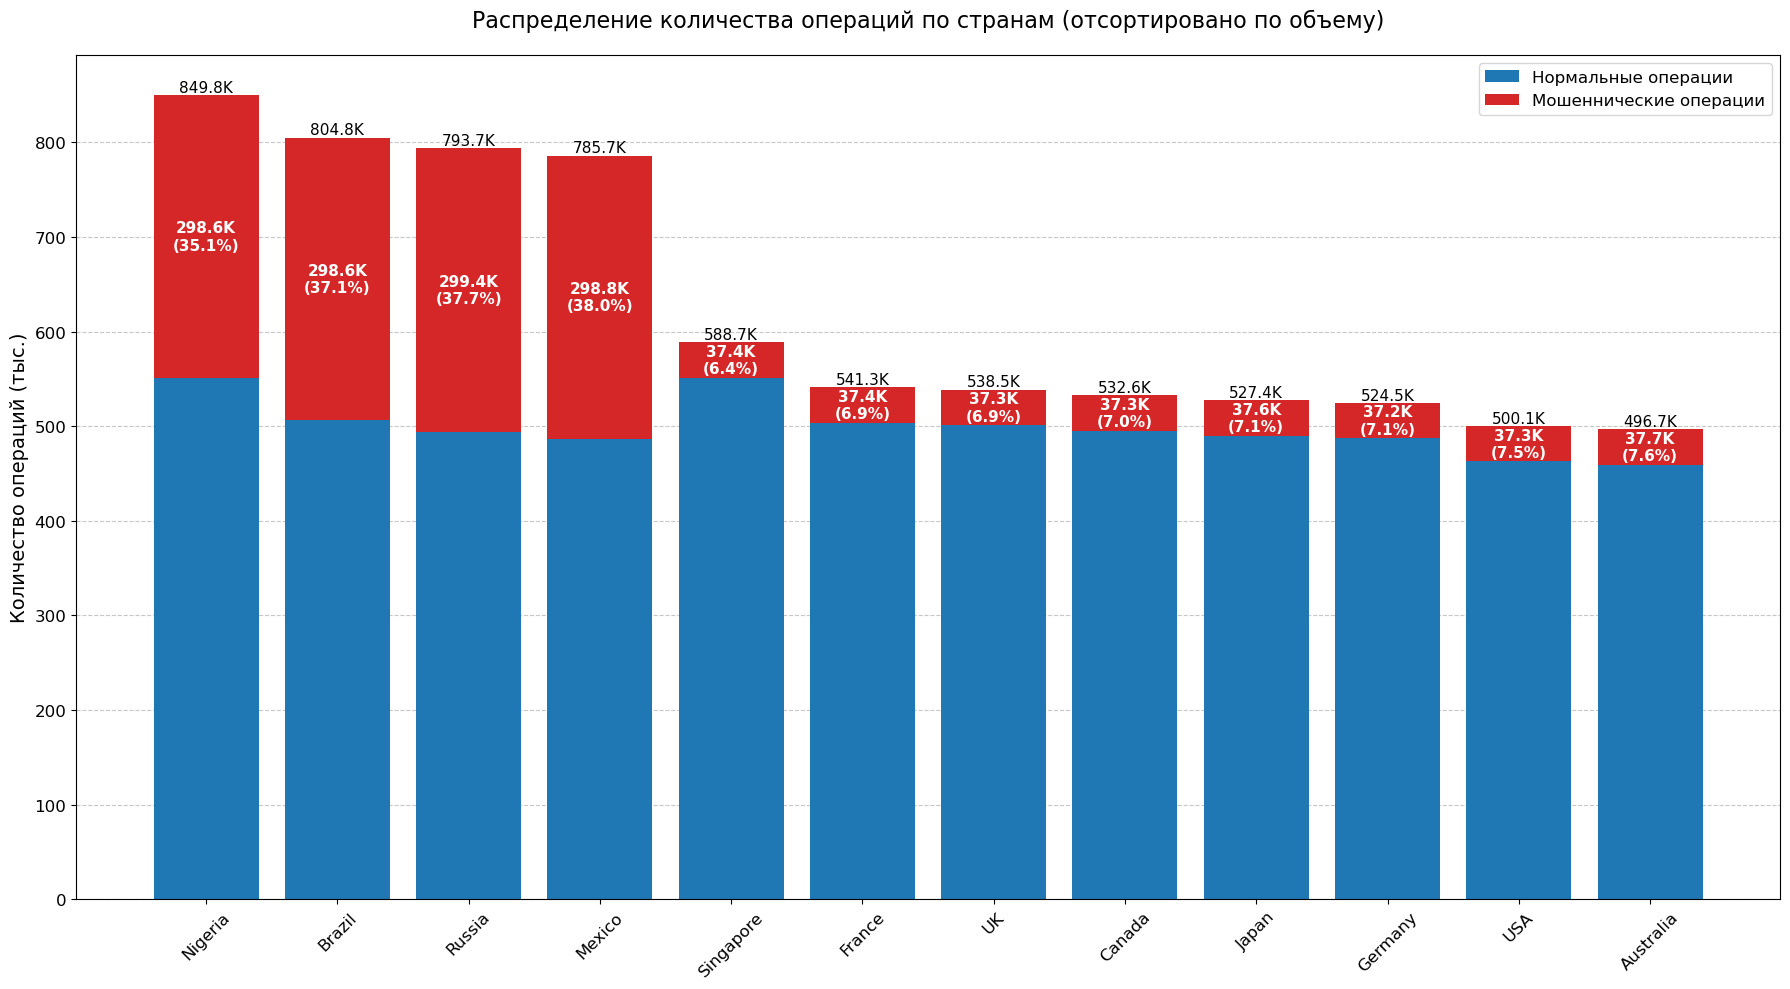

In [21]:
# Создаем country_stats с сортировкой по total_operations
country_stats = df.groupby('country')['is_fraud'].agg(
    total_operations='count',
    fraud_operations='sum'
).reset_index()
country_stats['fraud_percentage'] = (country_stats['fraud_operations'] / country_stats['total_operations']) * 100

# Сортируем от большего к меньшему
country_stats = country_stats.sort_values('total_operations', ascending=False)

plt.figure(figsize=(18, 10))
plt.rc('axes', axisbelow=True) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Округляем данные
total_k = country_stats['total_operations'] / 1000
fraud_k = country_stats['fraud_operations'] / 1000
normal_k = total_k - fraud_k
fraud_pct = country_stats['fraud_percentage']

bars_normal = plt.bar(country_stats['country'], normal_k, 
                     color='#1f77b4', label='Нормальные операции')
bars_fraud = plt.bar(country_stats['country'], fraud_k, 
                    bottom=normal_k, color='#d62728', label='Мошеннические операции')

plt.title('Распределение количества операций по странам (отсортировано по объему)', fontsize=16, pad=20)
plt.ylabel('Количество операций (тыс.)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Все операции 
for i, tot in enumerate(total_k):
    plt.text(i, tot + 0.5, f'{tot:.1f}K', 
             ha='center', va='bottom', fontsize=11)

# Мошеннические операции 
for i, (norm, frd, pct) in enumerate(zip(normal_k, fraud_k, fraud_pct)):
    if frd > 0:
        plt.text(i, norm + frd/2, f'{frd:.1f}K\n({pct:.1f}%)', 
                 ha='center', va='center', color='white',
                 fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

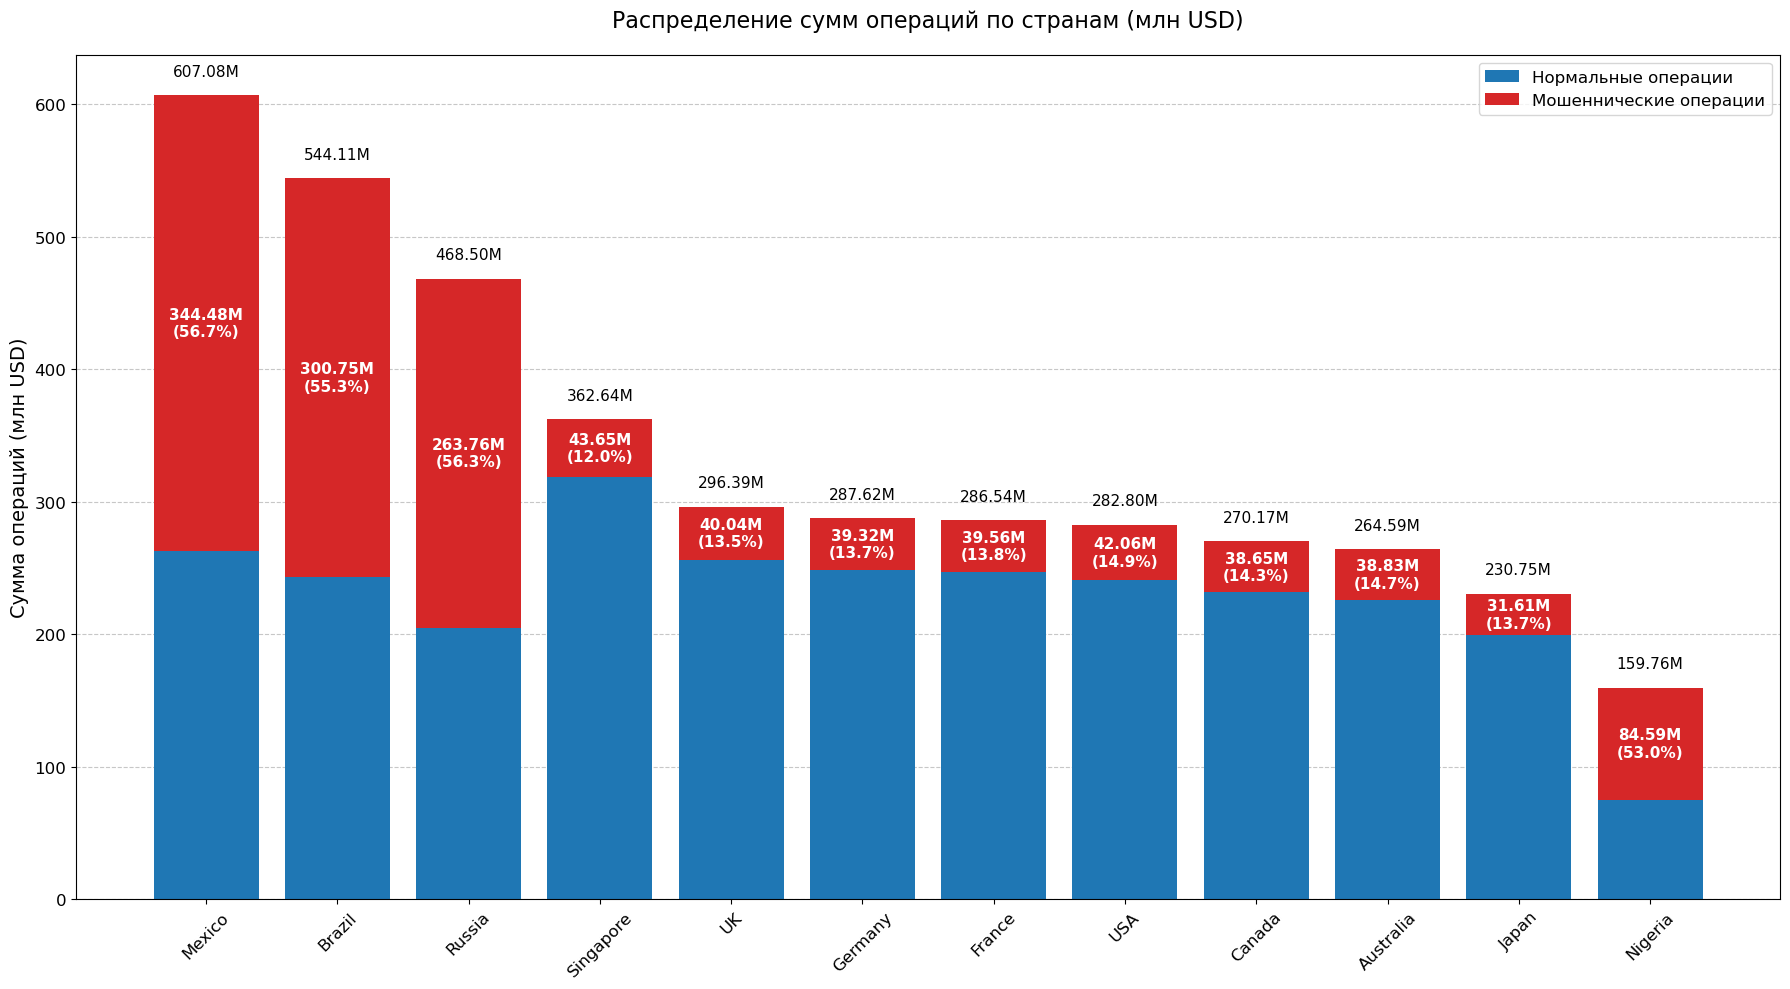

In [22]:
# Сначала группируем данные по странам и считаем суммы
country_amounts = df.groupby('country').agg(
    total_amount=('amount_USD', 'sum'),
    fraud_amount=('amount_USD', lambda x: x[df['is_fraud']].sum())
).reset_index()

# Рассчитываем нормальные операции и проценты
country_amounts['normal_amount'] = country_amounts['total_amount'] - country_amounts['fraud_amount']
country_amounts['fraud_percent'] = (country_amounts['fraud_amount'] / country_amounts['total_amount']) * 100

country_amounts = country_amounts.sort_values('total_amount', ascending=False)

plt.figure(figsize=(18, 10))
plt.rc('axes', axisbelow=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Данные в миллионах USD
total_m = country_amounts['total_amount'] / 1_000_000
fraud_m = country_amounts['fraud_amount'] / 1_000_000
normal_m = total_m - fraud_m
fraud_pct = country_amounts['fraud_percent']

bars_normal = plt.bar(country_amounts['country'], normal_m, 
                     color='#1f77b4', label='Нормальные операции')
bars_fraud = plt.bar(country_amounts['country'], fraud_m, 
                    bottom=normal_m, color='#d62728', label='Мошеннические операции')

plt.title('Распределение сумм операций по странам (млн USD)', fontsize=16, pad=20)
plt.ylabel('Сумма операций (млн USD)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Подписи (адаптивные по высоте)
max_total = total_m.max()
label_offset = max_total * 0.02

# Все суммы
plt.texts = [plt.text(i, tot + label_offset, f'{tot:.2f}M', 
             ha='center', va='bottom', fontsize=11) 
            for i, tot in enumerate(total_m)]

# Мошеннические суммы
plt.texts = [plt.text(i, norm + frd/2, f'{frd:.2f}M\n({pct:.1f}%)', 
             ha='center', va='center', color='white',
             fontweight='bold', fontsize=11)
            for i, (norm, frd, pct) in enumerate(zip(normal_m, fraud_m, fraud_pct))]

plt.tight_layout()
plt.show()

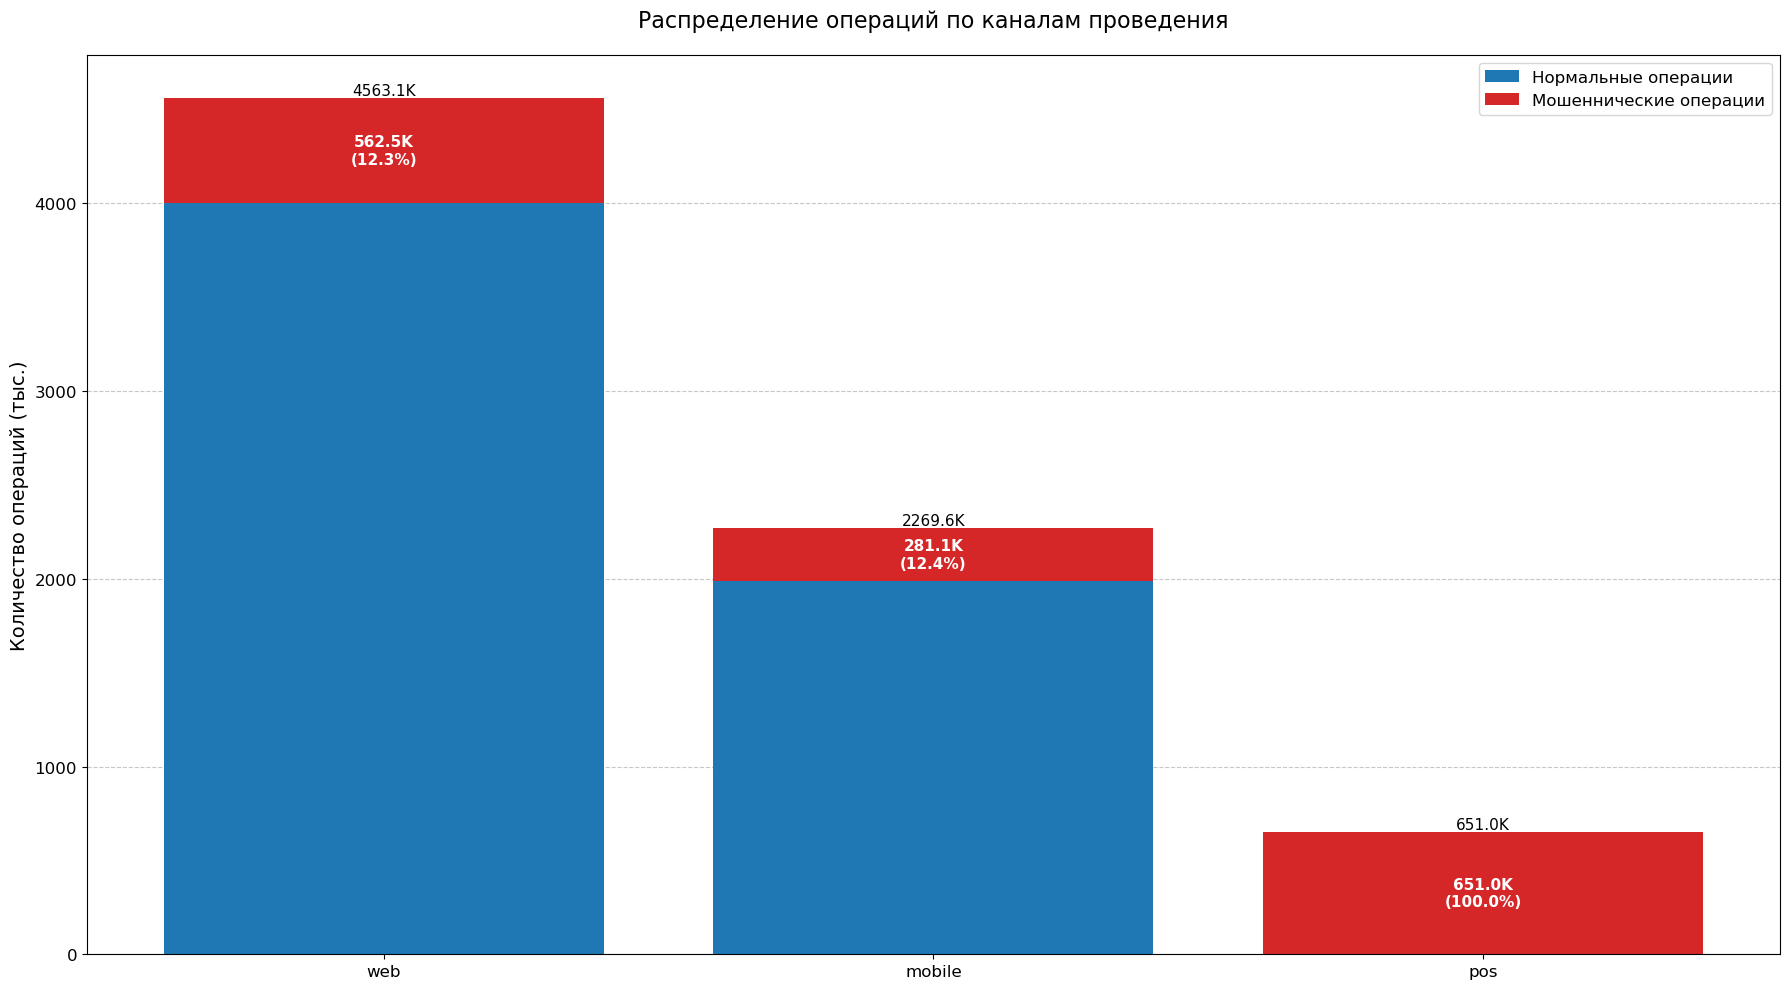

In [23]:
plt.figure(figsize=(18, 10))
plt.rc('axes', axisbelow=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Группировка данных
channel_stats = df.groupby('channel')['is_fraud'].agg(['count', 'sum'])
channel_stats['fraud_pct'] = channel_stats['sum'] / channel_stats['count'] * 100
channel_stats = channel_stats.sort_values('count', ascending=False)

# Округление данных
total_k = channel_stats['count'] / 1000
fraud_k = channel_stats['sum'] / 1000
normal_k = total_k - fraud_k

# Построение графика
bars_normal = plt.bar(channel_stats.index, normal_k, 
                     color='#1f77b4', label='Нормальные операции')
bars_fraud = plt.bar(channel_stats.index, fraud_k, 
                    bottom=normal_k, color='#d62728', label='Мошеннические операции')

plt.title('Распределение операций по каналам проведения', fontsize=16, pad=20)
plt.ylabel('Количество операций (тыс.)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Добавление подписей
for i, (tot, norm, frd, pct) in enumerate(zip(total_k, normal_k, fraud_k, channel_stats['fraud_pct'])):
    plt.text(i, tot + 0.1, f'{tot:.1f}K', ha='center', va='bottom', fontsize=11)
    if frd > 0:
        plt.text(i, norm + frd/2, f'{frd:.1f}K\n({pct:.1f}%)', 
                ha='center', va='center', color='white',
                fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

C:\Users\Роман\AppData\Local\Temp\ipykernel_10844\1516132035.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_stats = df.groupby(['day_of_week', 'is_fraud']).size().unstack(fill_value=0)


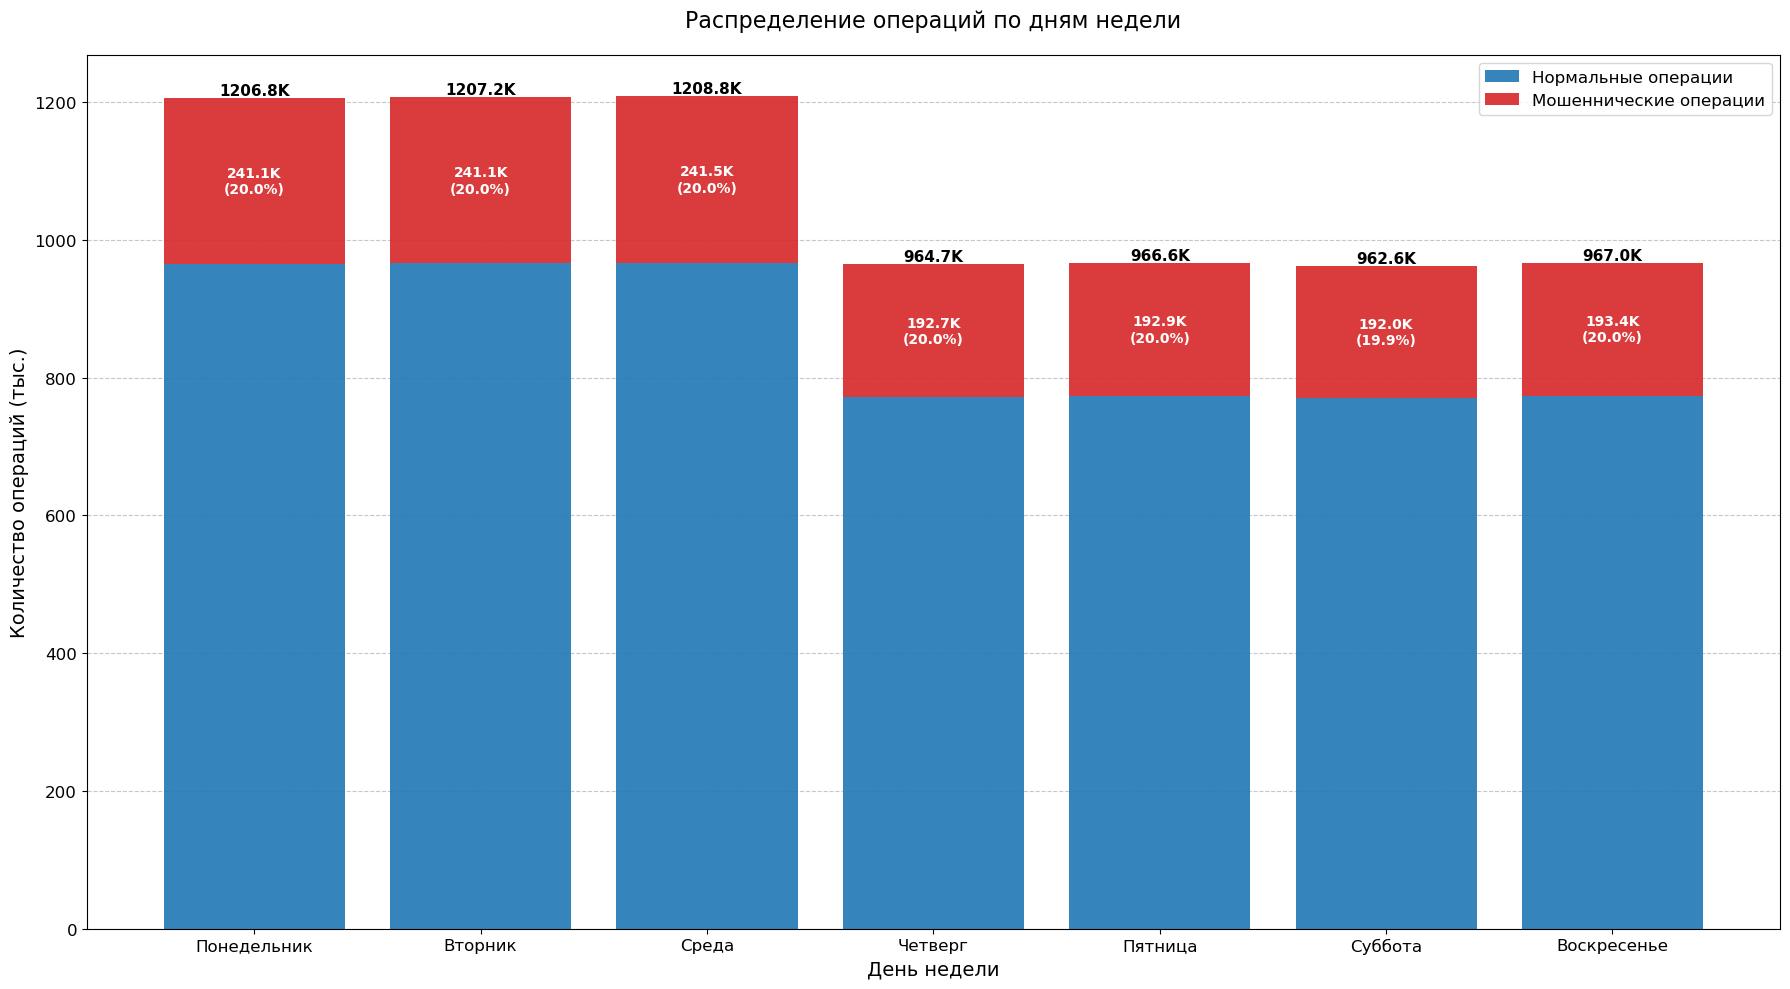

In [24]:
plt.figure(figsize=(18, 10))
plt.rc('axes', axisbelow=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Создаем дни недели
df['day_of_week'] = df['timestamp'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_order, ordered=True)

day_stats = df.groupby(['day_of_week', 'is_fraud']).size().unstack(fill_value=0)

# Нормальные и мошеннические операции
if False in day_stats.columns:
    normal_ops = day_stats[False] / 1000
else:
    normal_ops = pd.Series(0, index=days_order)
    
if True in day_stats.columns:
    fraud_ops = day_stats[True] / 1000
else:
    fraud_ops = pd.Series(0, index=days_order)

# Заполняем все дни недели
normal_ops = normal_ops.reindex(days_order, fill_value=0)
fraud_ops = fraud_ops.reindex(days_order, fill_value=0)

# Русские названия дней недели для отображения
russian_days = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

# Построение графика
bars_normal = plt.bar(range(len(days_order)), normal_ops, 
                     color='#1f77b4', label='Нормальные операции', alpha=0.9)
bars_fraud = plt.bar(range(len(days_order)), fraud_ops, 
                    bottom=normal_ops, color='#d62728', label='Мошеннические операции', alpha=0.9)

plt.title('Распределение операций по дням недели', fontsize=16, pad=20)
plt.xlabel('День недели', fontsize=14)
plt.ylabel('Количество операций (тыс.)', fontsize=14)
plt.xticks(range(len(days_order)), russian_days, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Добавление подписей - общее количество операций над столбцами
for i, day in enumerate(days_order):
    total_ops = normal_ops[day] + fraud_ops[day]
    if total_ops > 0:
        plt.text(i, total_ops + 0.1, f'{total_ops:.1f}K', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Добавление подписей для мошеннических операций внутри столбцов
for i, day in enumerate(days_order):
    if fraud_ops[day] > 0:
        fraud_pct = (fraud_ops[day] / (normal_ops[day] + fraud_ops[day]) * 100) if (normal_ops[day] + fraud_ops[day]) > 0 else 0
        plt.text(i, normal_ops[day] + fraud_ops[day]/2, f'{fraud_ops[day]:.1f}K\n({fraud_pct:.1f}%)', 
                ha='center', va='center', color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

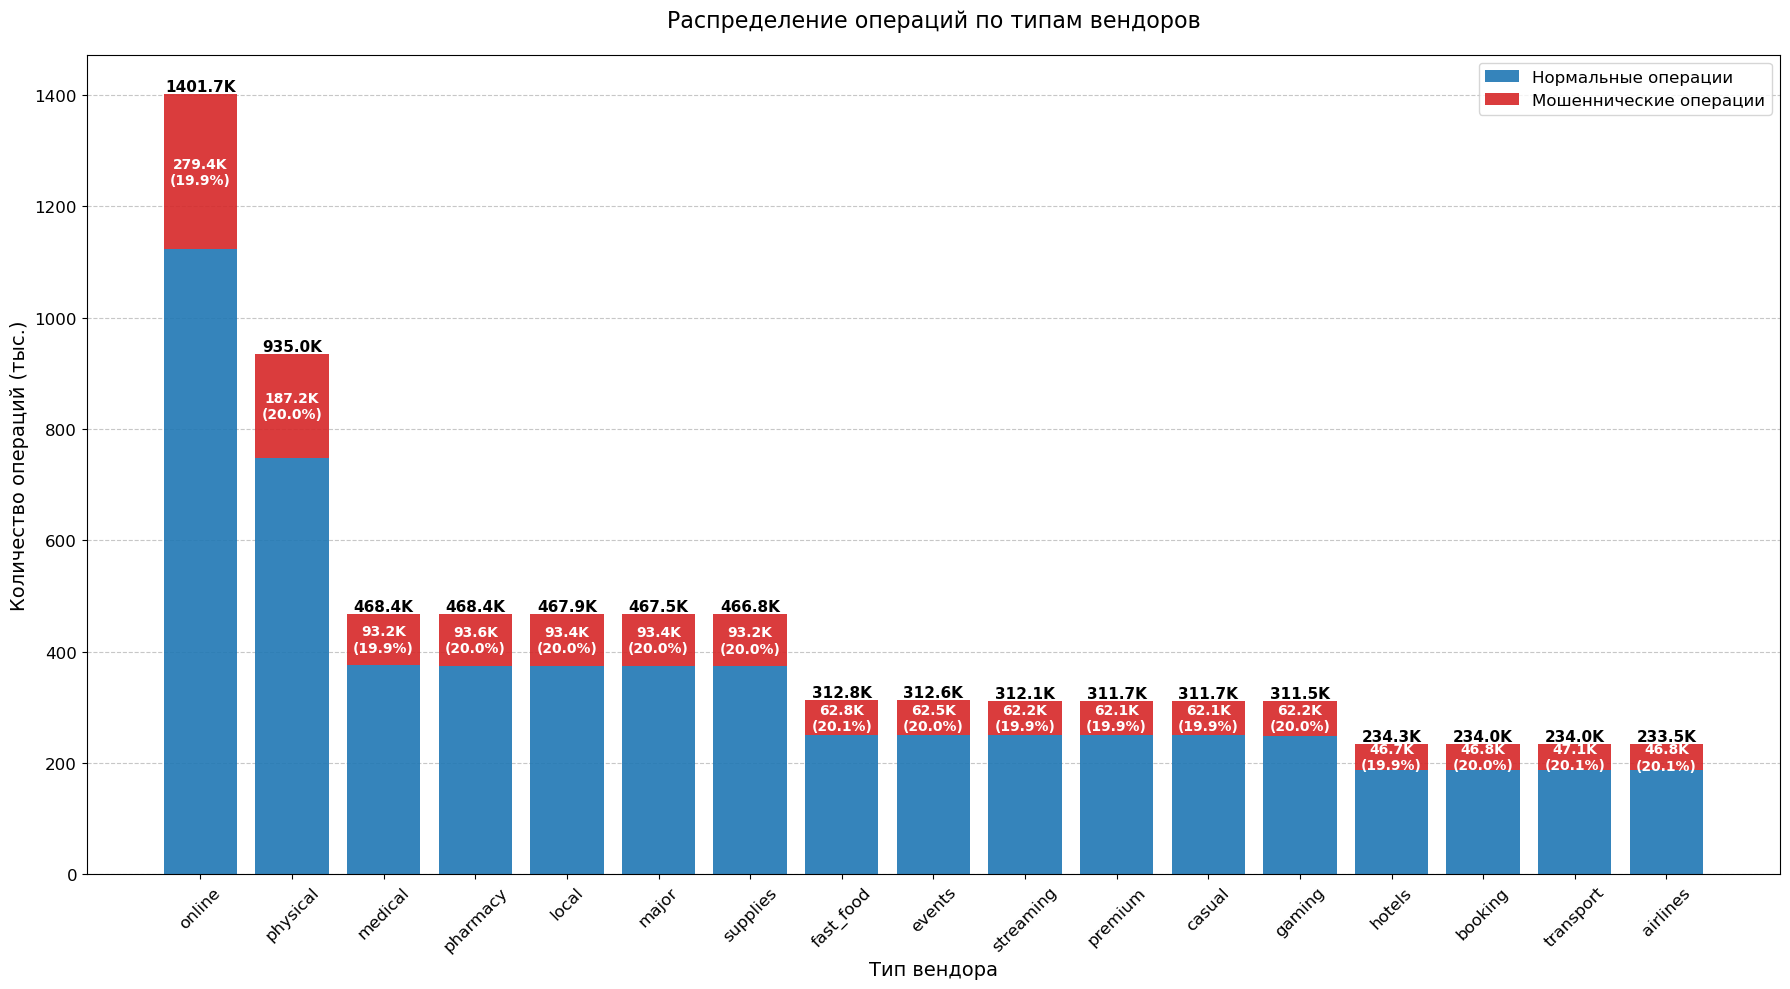

In [25]:
# Настройка стиля
plt.figure(figsize=(18, 10))
plt.rc('axes', axisbelow=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Группируем данные по vendor_type
vendor_stats = df.groupby(['vendor_type', 'is_fraud'], observed=False).size().unstack(fill_value=0)

# Нормальные и мошеннические операции
if False in vendor_stats.columns:
    normal_ops = vendor_stats[False] / 1000
else:
    normal_ops = pd.Series(0, index=vendor_stats.index)
    
if True in vendor_stats.columns:
    fraud_ops = vendor_stats[True] / 1000
else:
    fraud_ops = pd.Series(0, index=vendor_stats.index)

# Сортируем по общему количеству операций (от большего к меньшему)
total_ops = normal_ops + fraud_ops
sort_order = total_ops.sort_values(ascending=False).index

normal_ops = normal_ops[sort_order]
fraud_ops = fraud_ops[sort_order]

# Построение графика
bars_normal = plt.bar(range(len(normal_ops)), normal_ops, 
                     color='#1f77b4', label='Нормальные операции', alpha=0.9)
bars_fraud = plt.bar(range(len(fraud_ops)), fraud_ops, 
                    bottom=normal_ops, color='#d62728', label='Мошеннические операции', alpha=0.9)

plt.title('Распределение операций по типам вендоров', fontsize=16, pad=20)
plt.xlabel('Тип вендора', fontsize=14)
plt.ylabel('Количество операций (тыс.)', fontsize=14)
plt.xticks(range(len(normal_ops)), normal_ops.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Добавление подписей - общее количество операций над столбцами
for i, vendor_type in enumerate(normal_ops.index):
    total_ops = normal_ops[vendor_type] + fraud_ops[vendor_type]
    if total_ops > 0:
        plt.text(i, total_ops + 0.1, f'{total_ops:.1f}K', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Добавление подписей для мошеннических операций внутри столбцов
for i, vendor_type in enumerate(normal_ops.index):
    if fraud_ops[vendor_type] > 0:
        fraud_pct = (fraud_ops[vendor_type] / (normal_ops[vendor_type] + fraud_ops[vendor_type]) * 100) if (normal_ops[vendor_type] + fraud_ops[vendor_type]) > 0 else 0
        plt.text(i, normal_ops[vendor_type] + fraud_ops[vendor_type]/2, f'{fraud_ops[vendor_type]:.1f}K\n({fraud_pct:.1f}%)', 
                ha='center', va='center', color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

In [26]:
vc_fraud_stats = df[['vendor_category', 'is_fraud']].value_counts().unstack(fill_value=0)
vc_fraud_stats['Всего'] = vc_fraud_stats.sum(axis=1)
vc_fraud_stats['Мошенничество %'] = (vc_fraud_stats[1] / vc_fraud_stats['Всего'] * 100).round(1)

print(vc_fraud_stats)

is_fraud          False    True   Всего  Мошенничество %
vendor_category                                         
Education        747339  186203  933542             19.9
Entertainment    749283  186890  936173             20.0
Gas              748572  186829  935401             20.0
Grocery          747042  186987  934029             20.0
Healthcare       750001  186769  936770             19.9
Restaurant       749227  186951  936178             20.0
Retail           749270  186613  935883             19.9
Travel           748313  187477  935790             20.0


In [27]:
ct_fraud_stats = df[['card_type', 'is_fraud']].value_counts().unstack(fill_value=0)
ct_fraud_stats['Всего'] = ct_fraud_stats.sum(axis=1)
ct_fraud_stats['Мошенничество %'] = (ct_fraud_stats[1] / ct_fraud_stats['Всего'] * 100).round(1)

print(ct_fraud_stats)

is_fraud           False    True    Всего  Мошенничество %
card_type                                                 
Basic Credit     1132741  282728  1415469             20.0
Basic Debit      1239124  309239  1548363             20.0
Gold Credit      1158200  289060  1447260             20.0
Platinum Credit  1226823  306190  1533013             20.0
Premium Debit    1232159  307502  1539661             20.0


# 3. Технические гипотизы

## 3.1 В целевой переменной присутствует дисбаланс классов

In [28]:
counts = transaction_data['is_fraud'].value_counts()
legit, fraud = counts.iloc[0], counts.iloc[1]
legit_pct = legit / counts.sum() * 100
fraud_pct = fraud / counts.sum() * 100

print(f"Легитимные: {legit:>8,} ({legit_pct:.2f}%)")
print(f"Мошеннические: {fraud:>8,} ({fraud_pct:.2f}%)")

Легитимные: 5,989,047 (80.03%)
Мошеннические: 1,494,719 (19.97%)


## 3.2 В целевой переменной присутствует дисбаланс классов

In [29]:
ch_fraud_stats = df[['channel', 'is_fraud']].value_counts().unstack(fill_value=0)
ch_fraud_stats['Всего'] = ch_fraud_stats.sum(axis=1)
ch_fraud_stats['Мошенничество %'] = (ch_fraud_stats[1] / ch_fraud_stats['Всего'] * 100).round(1)

print(ch_fraud_stats)

is_fraud    False    True    Всего  Мошенничество %
channel                                            
mobile    1988428  281150  2269578             12.4
pos             0  651047   651047            100.0
web       4000619  562522  4563141             12.3


Явная неточность данных. ПОС операции на 100% состоят из фродовых операций, что странно, поскольку в физических магазинах совершать мошеннические операции более рискованно.

## 3.3 id транзакции не уникальное, хотя должно быть уникальным

In [30]:
transaction_data['transaction_id'].value_counts()

transaction_id
TX_9c2d174f    3
TX_eef2ac1b    3
TX_4e6f041a    3
TX_891636c5    3
TX_706baadf    3
              ..
TX_df6d0908    1
TX_35aae094    1
TX_8e0e7914    1
TX_9250b263    1
TX_7be21fc4    1
Name: count, Length: 7477306, dtype: int64

## 3.4 Столбец device содержит некорректные категории

In [32]:
df['device'].value_counts()

device
Edge               1189560
iOS App            1143461
Chrome             1132384
Android App        1126117
Firefox            1120952
Safari             1120245
Chip Reader         217324
Magnetic Stripe     217204
NFC Payment         216519
Name: count, dtype: int64

Действительно, здесь информация о составных частях банковской карты(NFC Payment, Magnetic Stripe, Chip Reader), браузерах (Edge, Chrome, Firefox, Safari) и операционных системах ( iOS App, Android App).

# 4. Бизнес-гипотизы

## 4.1 Проверить стериотип, что продукты Apple более устойчивы к фроду, чем продукты Android. 

In [33]:
mobile_data = df[df['device'].isin(['Android App', 'iOS App'])]

md_fraud_stats = mobile_data[['device', 'is_fraud']].value_counts().unstack(fill_value=0)
md_fraud_stats['Всего'] = md_fraud_stats.sum(axis=1)
md_fraud_stats['Мошенничество %'] = (md_fraud_stats[1] / md_fraud_stats['Всего'] * 100).round(1)

print(md_fraud_stats)

is_fraud       False    True    Всего  Мошенничество %
device                                                
Android App   985273  140844  1126117             12.5
iOS App      1003155  140306  1143461             12.3


## 4.2 У мошенников есть "популярные" категории вендоров  

In [34]:
vendor_fraud_analysis = df.groupby('vendor_category')['is_fraud'].agg([
    ('total_operations', 'count'),
    ('fraud_operations', 'sum'),
    ('fraud_rate', 'mean')
]).sort_values('fraud_rate', ascending=False)

vendor_fraud_analysis['fraud_percentage'] = vendor_fraud_analysis['fraud_rate'] * 100
vendor_fraud_analysis['share_of_total_fraud'] = vendor_fraud_analysis['fraud_operations'] / df['is_fraud'].sum() * 100

print("Анализ мошенничества по категориям вендоров:")
display(vendor_fraud_analysis.round(2))

Анализ мошенничества по категориям вендоров:


,total_operations,fraud_operations,fraud_rate,fraud_percentage,share_of_total_fraud
vendor_category,,,,,
Travel,935790,187477,0.2,20.03,12.54
Grocery,934029,186987,0.2,20.02,12.51
Gas,935401,186829,0.2,19.97,12.50
Restaurant,936178,186951,0.2,19.97,12.51
Entertainment,936173,186890,0.2,19.96,12.50
Education,933542,186203,0.2,19.95,12.46
Retail,935883,186613,0.2,19.94,12.48
Healthcare,936770,186769,0.2,19.94,12.50


## 4.3 Ночью больше фрода

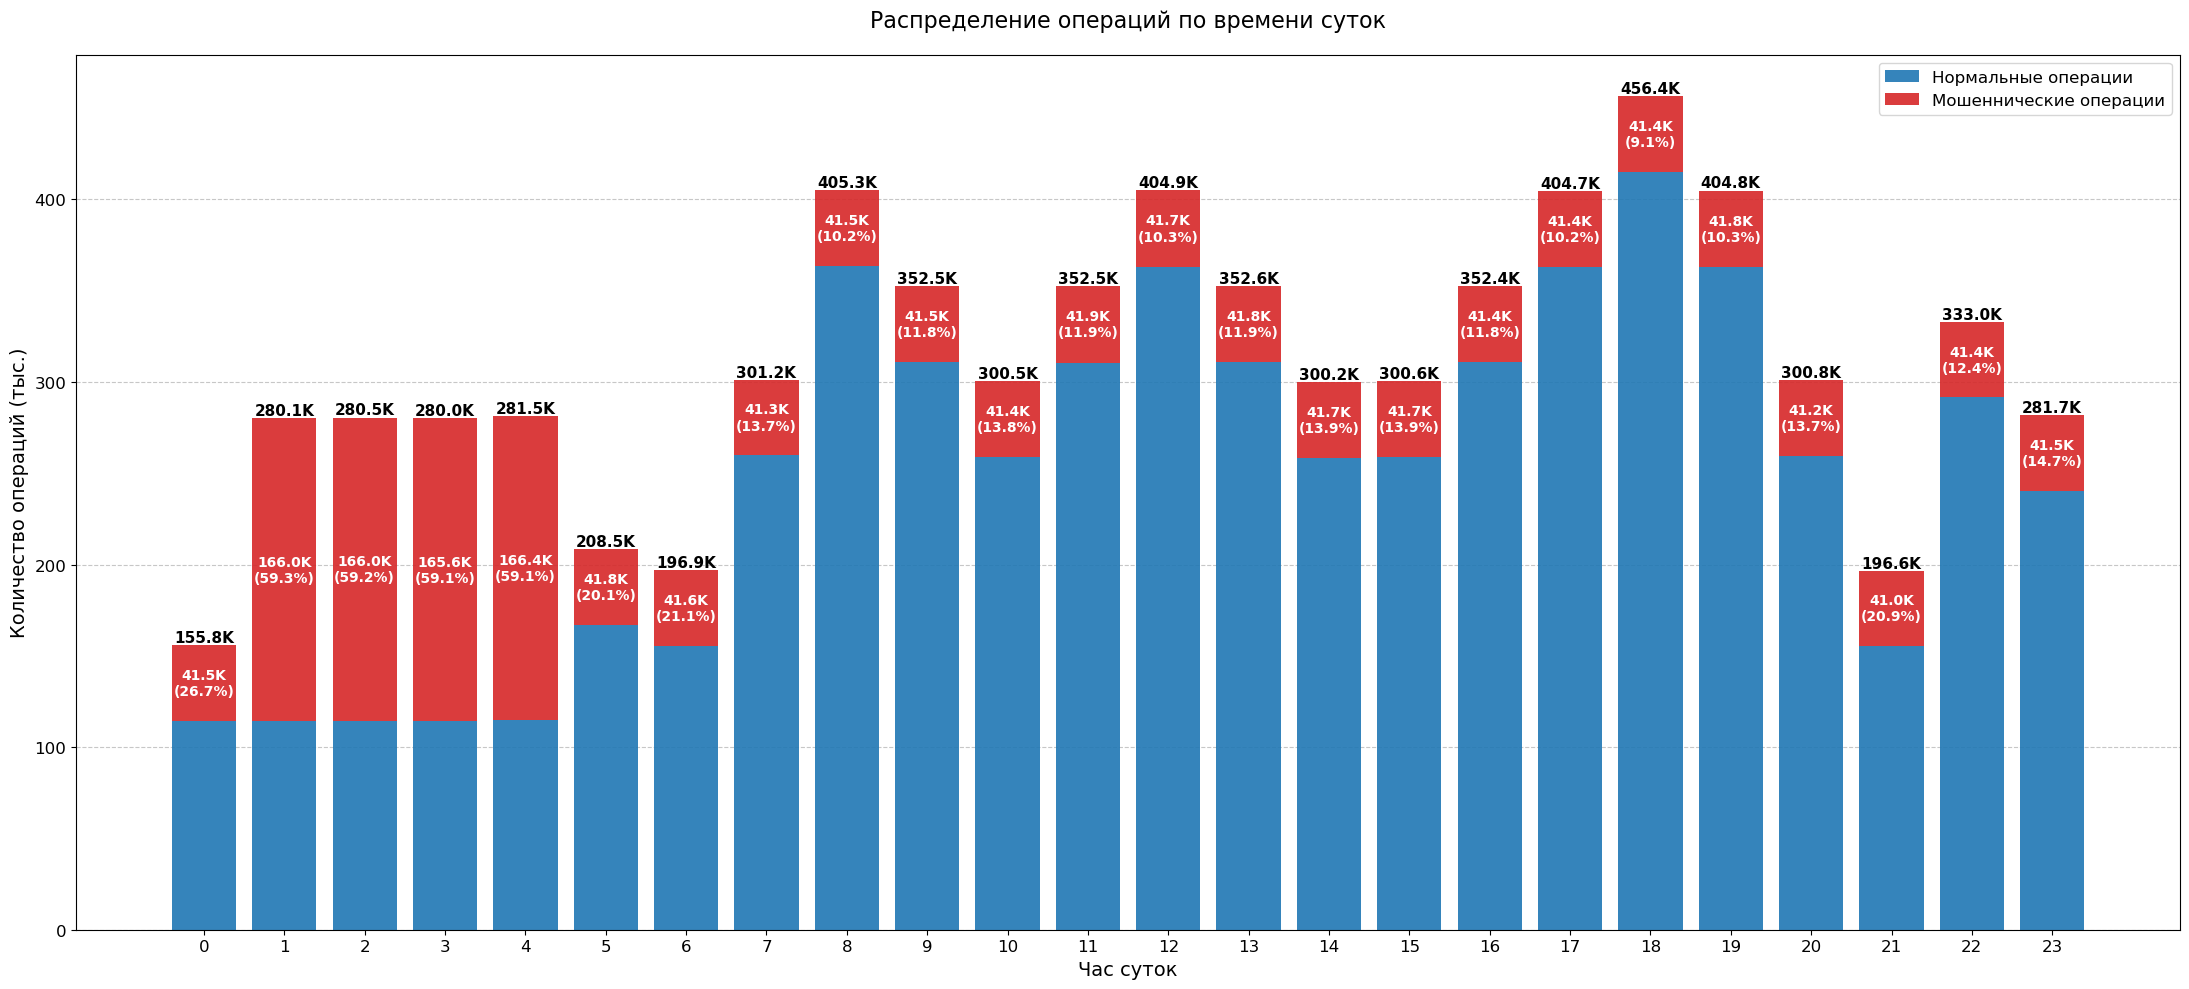

In [35]:
plt.figure(figsize=(22, 10))
plt.rc('axes', axisbelow=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Создаем временные интервалы (часы суток)
df['hour'] = df['timestamp'].dt.hour
time_stats = df.groupby(['hour', 'is_fraud']).size().unstack(fill_value=0)

# Нормальные и мошеннические операции
if False in time_stats.columns:
    normal_ops = time_stats[False] / 1000
else:
    normal_ops = pd.Series(0, index=range(24))
    
if True in time_stats.columns:
    fraud_ops = time_stats[True] / 1000
else:
    fraud_ops = pd.Series(0, index=range(24))

# Заполняем все часы (0-23)
normal_ops = normal_ops.reindex(range(24), fill_value=0)
fraud_ops = fraud_ops.reindex(range(24), fill_value=0)

# Построение графика
bars_normal = plt.bar(normal_ops.index, normal_ops, 
                     color='#1f77b4', label='Нормальные операции', alpha=0.9)
bars_fraud = plt.bar(fraud_ops.index, fraud_ops, 
                    bottom=normal_ops, color='#d62728', label='Мошеннические операции', alpha=0.9)

plt.title('Распределение операций по времени суток', fontsize=16, pad=20)
plt.xlabel('Час суток', fontsize=14)
plt.ylabel('Количество операций (тыс.)', fontsize=14)
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Добавление подписей - общее количество операций над столбцами
for hour in range(24):
    total_ops = normal_ops[hour] + fraud_ops[hour]
    if total_ops > 0:
        plt.text(hour, total_ops + 0.1, f'{total_ops:.1f}K', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Добавление подписей для мошеннических операций внутри столбцов
for hour in range(24):
    if fraud_ops[hour] > 0:
        fraud_pct = (fraud_ops[hour] / (normal_ops[hour] + fraud_ops[hour]) * 100) if (normal_ops[hour] + fraud_ops[hour]) > 0 else 0
        plt.text(hour, normal_ops[hour] + fraud_ops[hour]/2, f'{fraud_ops[hour]:.1f}K\n({fraud_pct:.1f}%)', 
                ha='center', va='center', color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## 4.4 Рисковые вендоры борются  мошенниками хуже нерисковых

In [36]:
# Топ 5 рисковых вендоров по обороту (is_high_risk_vendor = True)
top_risky_vendors = df[df['is_high_risk_vendor']].groupby('vendor')['amount'].sum().nlargest(5)

# Топ 5 нерисковых вендоров по обороту (is_high_risk_vendor = False)  
top_safe_vendors = df[~df['is_high_risk_vendor']].groupby('vendor')['amount'].sum().nlargest(5)

# Анализ уровня мошенничества
risky_fraud_analysis = df[df['vendor'].isin(top_risky_vendors.index)].groupby('vendor')['is_fraud'].agg([
    ('total_operations', 'count'),
    ('fraud_operations', 'sum'), 
    ('fraud_rate', 'mean'),
    ('total_amount', lambda x: df[df['vendor'] == x.name]['amount'].sum())
]).sort_values('fraud_rate', ascending=False)

safe_fraud_analysis = df[df['vendor'].isin(top_safe_vendors.index)].groupby('vendor')['is_fraud'].agg([
    ('total_operations', 'count'),
    ('fraud_operations', 'sum'),
    ('fraud_rate', 'mean'), 
    ('total_amount', lambda x: df[df['vendor'] == x.name]['amount'].sum())
]).sort_values('fraud_rate', ascending=False)

print("Топ 5 рисковых вендоров (по обороту):")
display(risky_fraud_analysis.round(4))

print("\nТоп 5 нерисковых вендоров (по обороту):")
display(safe_fraud_analysis.round(4))

# Сравнительная статистика
print(f"\nСредний уровень фрода:")
print(f"Рисковые вендоры: {risky_fraud_analysis['fraud_rate'].mean()*100:.3f}%")
print(f"Нерисковые вендоры: {safe_fraud_analysis['fraud_rate'].mean()*100:.3f}%")

Топ 5 рисковых вендоров (по обороту):


,total_operations,fraud_operations,fraud_rate,total_amount
vendor,,,,
Airbnb,46682,9407,0.2015,0.0
Booking.com,46672,9378,0.2009,0.0
Hotels.com,46782,9377,0.2004,0.0
Kayak,46971,9389,0.1999,0.0
Expedia,46919,9295,0.1981,0.0



Топ 5 нерисковых вендоров (по обороту):


,total_operations,fraud_operations,fraud_rate,total_amount
vendor,,,,
Local Gas Station,155977,31205,0.2001,0.0
Truck Stop,155945,31192,0.2000,0.0
University Bookstore,155827,31136,0.1998,0.0
Chegg,156105,31171,0.1997,0.0
Highway Gas Stop,155980,31016,0.1988,0.0



Средний уровень фрода:
Рисковые вендоры: 20.018%
Нерисковые вендоры: 19.968%


## 4.5 Транзакция с нового устройства с большей долей вероятности фродовая 

In [39]:
# Анализ мошенничества по новым устройствам
device_fraud_analysis = df.groupby('new_device')['is_fraud'].agg([
    ('total_operations', 'count'),
    ('fraud_operations', 'sum'),
    ('fraud_rate', 'mean')
])

device_fraud_analysis['fraud_percentage'] = device_fraud_analysis['fraud_rate'] * 100

print("Анализ мошенничества по новым устройствам:")
display(device_fraud_analysis.round(4))

Анализ мошенничества по новым устройствам:


,total_operations,fraud_operations,fraud_rate,fraud_percentage
new_device,,,,
0,7439945,1460779,0.1963,19.6343
1,43821,33940,0.7745,77.4515


## 4.6 В зарубежных операциях доля фрода выше

In [38]:
# Анализ мошенничества по зарубежным операциям
abroad_fraud_analysis = df.groupby('is_outside_home_country')['is_fraud'].agg([
    ('total_operations', 'count'),
    ('fraud_operations', 'sum'),
    ('fraud_rate', 'mean')
])

abroad_fraud_analysis['fraud_percentage'] = abroad_fraud_analysis['fraud_rate'] * 100

print("Анализ мошенничества по зарубежным операциям:")
display(abroad_fraud_analysis.round(4))

Анализ мошенничества по зарубежным операциям:


,total_operations,fraud_operations,fraud_rate,fraud_percentage
is_outside_home_country,,,,
False,5073605,126343,0.0249,2.4902
True,2410161,1368376,0.5678,56.7753
